In [1]:
# general imports
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns

# from our documents
import OurFunctions as of

# from Scikit Learn library
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import plot_tree
from sklearn.calibration import CalibratedClassifierCV

# from Imb Learn
from imblearn.over_sampling import SMOTENC, SMOTE



We start importing our datasets, where ASD_phenotypic_original is the untouched dataset, ASD_phenotypic is the one proceding from the preprocessing and where the ASD_diagnosis dataset contains its respectives DX_GROUP.

In [2]:
ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic.csv'))
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic_preprocessed.csv'))
ASD_diagnosis = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_clinical.csv'))

# CLASSIFICATION

First of all, we split the data into train set and test set, to be sure that our classifier is evaluated on data that it had never seen before.

In [3]:
#ASD_phenotypic = ASD_phenotypic.drop(columns=["SITE_ID", "VIQ_TEST_TYPE", "FIQ_TEST_TYPE", "PIQ_TEST_TYPE"])
ASD_phenotypic = ASD_phenotypic.drop(columns=["SITE_ID"])
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic, ASD_diagnosis['DX_GROUP'], test_size=0.3, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (467, 8)
Test set size: (201, 8)


We want to check the balance between classes for each set, to  be sure we are training the classifier using a good split.

In [4]:
class_counts_test = y_test.value_counts(normalize=True)
class_counts_train = y_train.value_counts(normalize=True)
class_count_train_num = y_train.value_counts()

# Stampa il conteggio delle classi per DX_GROUP
print("Class proportions for:")
print("- test set: " + str(class_counts_test))
print("- train set: " + str(class_counts_train))
print("Num subjects involved per "+ str(class_count_train_num))

Class proportions for:
- test set: DX_GROUP
1    0.60199
2    0.39801
Name: proportion, dtype: float64
- train set: DX_GROUP
1    0.603854
2    0.396146
Name: proportion, dtype: float64
Num subjects involved per DX_GROUP
1    282
2    185
Name: count, dtype: int64


In order to fix the umbalancing for the training phase, we use SMOTENC (variable of SMOTE that can handle categorical features), to create fictious subjects and rebalance them.

In [5]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_features = categorical_columns.tolist()

# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# Stampa la distribuzione delle classi dopo l'applicazione di SMOTE-NC
print(pd.Series(Y_SMOTE).value_counts(normalize=True))
print("Num subjects involved per")
print(pd.Series(Y_SMOTE).value_counts())

#sampler = SMOTE(random_state=42) --> in case we want to use only numeric

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# Stampa la distribuzione delle classi dopo l'applicazione di SMOTE-NC
print(pd.Series(Y_SMOTE).value_counts(normalize=True))
print("Num subjects involved per")
print(pd.Series(Y_SMOTE).value_counts())

DX_GROUP
1    0.5
2    0.5
Name: proportion, dtype: float64
Num subjects involved per
DX_GROUP
1    282
2    282
Name: count, dtype: int64
DX_GROUP
1    0.5
2    0.5
Name: proportion, dtype: float64
Num subjects involved per
DX_GROUP
1    282
2    282
Name: count, dtype: int64


We can see that the dataset is unbalanced, having 60% of the subjects with autism condition. However, the split separates train and test sets respecting the proportion.

## General pipeline

The pipeline receive as mandatory arguments the dataset, the target and the chosen classifier, it also has some optional parameters that can specify some actions or parameters.

- To achieve a more reliable accuracy score we use k-fold cross validation. In this way we are performing the training on different train and validation fold and we avoid to have a better accuracy based only on the subjects we selected (k of cv can be set up from the outside).
- There exist the option to select if to use an encoder or a scaler (by default both options are set to true).
- The pipeline execute grid search to find the best hyperparameters per our training.
- The grid search can use both default parameters present in the function or gived by the useer as well.
- The algorithm can handle three different types of classifier: KNearestNeighbors, RandomForestClassifier and LinearSupportVectorMachine.
- The feature selection can be integrated to the pipeline if requested.

The output is composed by the trained model, the best_parameters found by the grid search, the best achieved accuracy, and if in case the feature_selector is activated, also the selected_features.


In [6]:
def general_pipeline(dataset, target, classifier, encoder = True, scaler = True, parameters_grid_search = None, cv = None, feature_selector=False,  parameters_feature_selector = None):

    # Definizione delle metriche da utilizzare come scoring
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }

    # Preprocess to make on the train data may include
    # - normalization of the numerical columns
    # - one hot encoding on the categorical columns
    
    categorical_columns = dataset.select_dtypes(include=['object']).columns

    if not encoder:
        transformers = [('num', RobustScaler(), ~dataset.columns.isin(categorical_columns))]
    elif not scaler:
        transformers = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)]
    elif not encoder and not scaler:
        transformers = []
    else:
        transformers=[
            ('num', RobustScaler(), ~dataset.columns.isin(categorical_columns)),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ]

    preprocessor = ColumnTransformer(transformers=transformers)

    if isinstance(classifier, KNeighborsClassifier):
        parameter_type = 'classifier__n_neighbors'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # Valori di n_neighbors da esplorare
        else:
            parameters = {parameter_type: [3, 5, 7, 9, 11]}  # Valori di n_neighbors da esplorare

        #feature_selector_type = SFS(classifier)
        #selector_parameter = 'feature_selection__n_features_to_select'
        #per default is forward, but if you need to change --> parameters.update({'sfs__direction': ['forward']})
        feature_selector_type = SelectKBest(score_func=f_classif)
        selector_parameter = 'feature_selection__k'
        

    if isinstance(classifier, RandomForestClassifier):
        parameter_type = 'classifier__n_estimators'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [10, 50, 200, 500, 1000]} 

        feature_selector_type = RFE(estimator=classifier)
        selector_parameter = 'feature_selection__n_features_to_select'

    if isinstance(classifier, CalibratedClassifierCV):
        parameter_type = 'classifier__estimator__C'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [1]}  

        #feature_selector_type = SelectFromModel(LinearSVC(penalty='l1', dual=False))
        #selector_parameter = 'feature_selection__max_features'
        feature_selector_type = RFE(estimator=LinearSVC(dual=False))
        selector_parameter = 'feature_selection__n_features_to_select'

    if feature_selector:
        # Initialize RFE with the fitted classifier
        sample_transformed = preprocessor.fit_transform(dataset)
        n_total_features = sample_transformed.shape[1]
        print("Total quantity of features after one hot encoding :" + str(n_total_features))
        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector_type),
        ('classifier', classifier)  
        ])
        if parameters_feature_selector:
            parameters.update({selector_parameter: parameters_feature_selector})
        else: 
            parameters.update({selector_parameter: list(range(1, n_total_features+1))})
            
    else:
    # We define the pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier),
            ])

    if cv:
        k_folds = cv
    else:
        k_folds = 5

    # Creazione dell'oggetto GridSearchCV
    grid_search = GridSearchCV(pipeline, parameters, cv= k_folds, scoring=scoring, refit='accuracy')

    # Esecuzione della ricerca a griglia
    grid_search.fit(dataset, target)

    # Visualizzazione dei risultati

    means_accuracy = grid_search.cv_results_['mean_test_accuracy']
    stds_accuracy = grid_search.cv_results_['std_test_accuracy']
    means_precision = grid_search.cv_results_['mean_test_precision']
    means_recall = grid_search.cv_results_['mean_test_recall']
    means_f1_score = grid_search.cv_results_['mean_test_f1_score']
    params = grid_search.cv_results_['params']

    best_model = grid_search.best_estimator_
    best_parameter = [grid_search.best_params_[parameter_type]]
    best_accuracy = grid_search.best_score_

    if not parameters_grid_search: #the parameter is not choose from the outside
        print("Risultati della cross-validation per tutte le combinazioni di iperparametri:")
        for mean_acc, std_acc, mean_prec, mean_rec, mean_f1, params in zip(means_accuracy, stds_accuracy, means_precision, means_recall, means_f1_score, params):
            print(f"Parameters: {params}, Accuracy: {mean_acc:.3f} (±{std_acc:.3f}), Precision: {mean_prec:.3f}, Recall: {mean_rec:.3f}, F1-score: {mean_f1:.3f}")

        print("\nBest parameter founded:")
        print(best_parameter)
        print("Accuracy with best parameter:", best_accuracy)

    if feature_selector:
        # Get the support mask and selected feature names from the preprocessed data
        selected_mask = best_model.named_steps['feature_selection'].get_support()
        feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        selected_features = []
        for feature in feature_names[selected_mask]:
            selected_features.append(feature)

        
        print("\nSelected features are:")
        print(f"Number of selected features: {len(selected_features)}")
        print("Selected features:", selected_features)

        non_selected_mask = ~selected_mask
        non_selected_features = feature_names[non_selected_mask]

        print("\nNon selected features are:")
        print(f"Number of non selected features: {len(non_selected_features)}")
        print("Selected features:", non_selected_features)

        best_parameter.append(grid_search.best_params_[selector_parameter])

        return best_model, best_parameter, best_accuracy, selected_features
        
    return best_model, best_parameter, best_accuracy, None
    

## General classifiers

We start training our classifiers with the default values, so we can find the most accurate parameters for the training.

### K-NEAREST NEIGHBOOR

In [7]:
classifier = KNeighborsClassifier()
knn_model, knn_parameter, knn_accuracy, _= general_pipeline(X_SMOTE, Y_SMOTE, classifier)


Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__n_neighbors': 3}, Accuracy: 0.855 (±0.034), Precision: 0.943, Recall: 0.756, F1-score: 0.838
Parameters: {'classifier__n_neighbors': 5}, Accuracy: 0.835 (±0.036), Precision: 0.929, Recall: 0.728, F1-score: 0.814
Parameters: {'classifier__n_neighbors': 7}, Accuracy: 0.832 (±0.046), Precision: 0.923, Recall: 0.724, F1-score: 0.810
Parameters: {'classifier__n_neighbors': 9}, Accuracy: 0.832 (±0.045), Precision: 0.930, Recall: 0.717, F1-score: 0.809
Parameters: {'classifier__n_neighbors': 11}, Accuracy: 0.830 (±0.036), Precision: 0.956, Recall: 0.692, F1-score: 0.802

Best parameter founded:
[3]
Accuracy with best parameter: 0.8546776232616942


As we seen, we found that the best accuracy of the model is achieved using 3 Knn and we obtained 0.855.

Now se test the algorithm on unseen data.

In [8]:
# Valutazione del modello sui dati di test
y_pred = knn_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.886
Precisione: 0.945
Richiamo: 0.860
F1-score: 0.900


We can see that the accuracy still be good (moreover, is greater) 0.886. 

To have a better idea of the performance, we display also the confusion matrix.

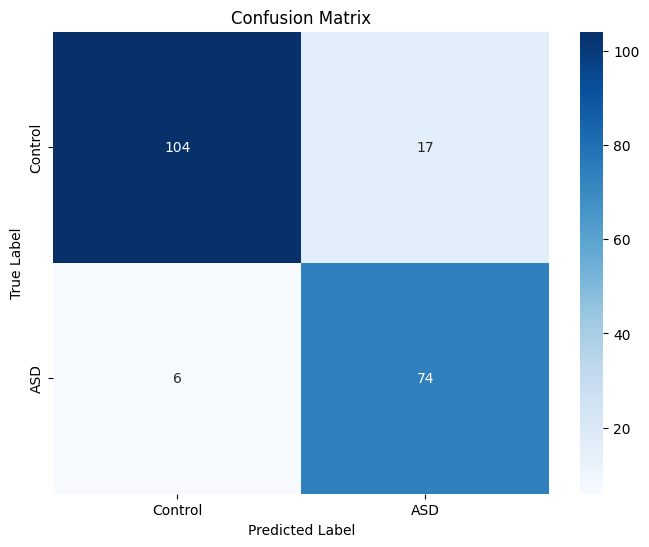

In [9]:
# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


We can observe that in general we have a good fit, but there are many persons that are misclassified.

### Random Forest

To use the Random Forest classifier, I need to have only numerical features, so we will use one-hot-encoding to turn the categorical features (which aren't ordinal) into numerical features. It's not necessary to perform any normalization, but as we want to compare the performance of this classifier with others that use normalization, we will also use normalized data to train this classifier (it's not harmfull for the Random Forest Classifier).

In [10]:
classifier = RandomForestClassifier(random_state=1234)
rf_model, rf_parameter, rf_accuracy, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__n_estimators': 10}, Accuracy: 0.915 (±0.023), Precision: 0.919, Recall: 0.915, F1-score: 0.915
Parameters: {'classifier__n_estimators': 50}, Accuracy: 0.915 (±0.012), Precision: 0.946, Recall: 0.883, F1-score: 0.912
Parameters: {'classifier__n_estimators': 200}, Accuracy: 0.915 (±0.013), Precision: 0.946, Recall: 0.883, F1-score: 0.912
Parameters: {'classifier__n_estimators': 500}, Accuracy: 0.913 (±0.015), Precision: 0.943, Recall: 0.883, F1-score: 0.910
Parameters: {'classifier__n_estimators': 1000}, Accuracy: 0.917 (±0.014), Precision: 0.949, Recall: 0.883, F1-score: 0.914

Best parameter founded:
[1000]
Accuracy with best parameter: 0.9167035398230088


We found that the best accuracy, 0.917 is achieved using 1000 trees.

In [11]:
# Valutazione del modello sui dati di test
y_pred = rf_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.955
Precisione: 0.959
Richiamo: 0.967
F1-score: 0.963


In this case we also have higher accuracy on the test set, 0.955.

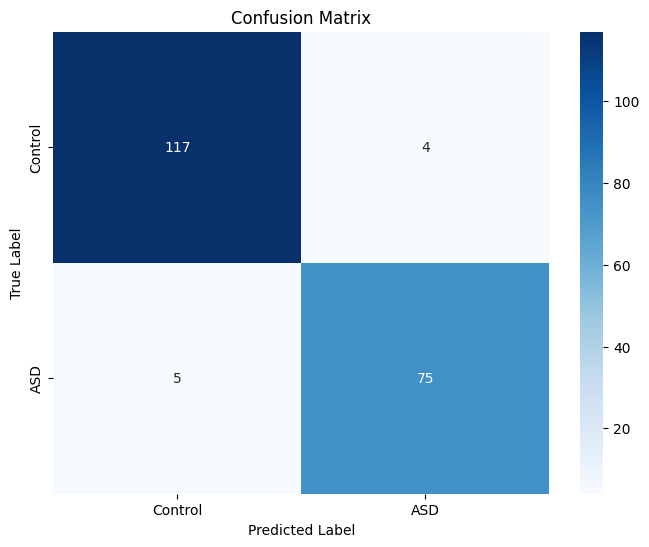

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Accordly to what we said before, there is an higher accuracy in the model, so we have a better fit of the model to the labeled data.

### Support vector machine

We still using the default parameters. Note: we use the calibrated classifier cv on the LinearSVC to enable the possibility to compute the ROC.

In [13]:
classifier = CalibratedClassifierCV(LinearSVC(dual=False))
svc_model, svc_parameter, svc_accuracy, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__estimator__C': 1}, Accuracy: 0.869 (±0.026), Precision: 0.925, Recall: 0.805, F1-score: 0.860

Best parameter founded:
[1]
Accuracy with best parameter: 0.8688685208596713


In this case we didn't really perfomed the grid search, because this method is not sensitive to an external parameter to work. The best accuracy encountered is 0.869.

In [14]:
# Valutazione del modello sui dati di test
y_pred = svc_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.905
Precisione: 0.947
Richiamo: 0.893
F1-score: 0.919


Also in this case there is an increase of accuracy using test data, going to 0.905.

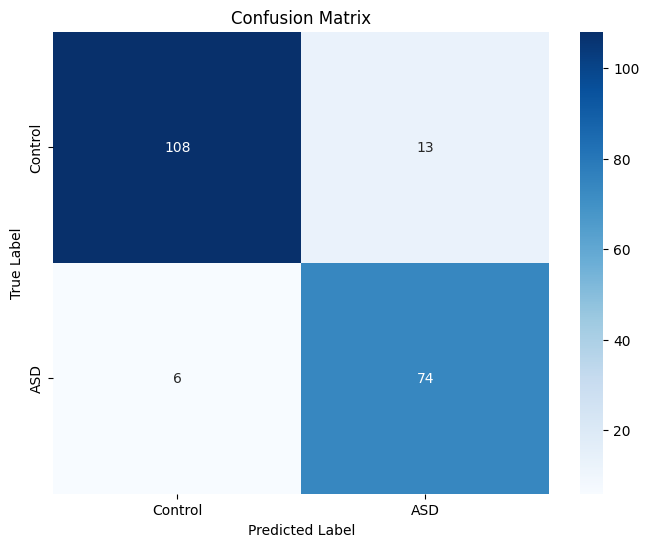

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


As we can see, this algorithm has a worst performance than RFC, but better than KNN. 

To check this, we will perform a comparison between them.

# Comparison Between Classifiers

To better compare the classifiers we evaluate the area under the ROC curve per each classifier.

In [16]:
# Define a function to evaluate the AUC-ROC for a given model
def evaluate_roc_auc(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_proba)
    return auc_roc

knn_auc_roc = evaluate_roc_auc(knn_model, X_test, y_test)
rf_auc_roc = evaluate_roc_auc(rf_model, X_test, y_test)
svc_auc_roc = evaluate_roc_auc(svc_model, X_test, y_test)

# Print the results
print("K-Nearest Neighbors Classifier AUC-ROC:", knn_auc_roc)
print("Random Forest Classifier AUC-ROC:", rf_auc_roc)
print("Support vector Classifier AUC-ROC:", svc_auc_roc)


K-Nearest Neighbors Classifier AUC-ROC: 0.9331611570247933
Random Forest Classifier AUC-ROC: 0.9802685950413222
Support vector Classifier AUC-ROC: 0.9727272727272727


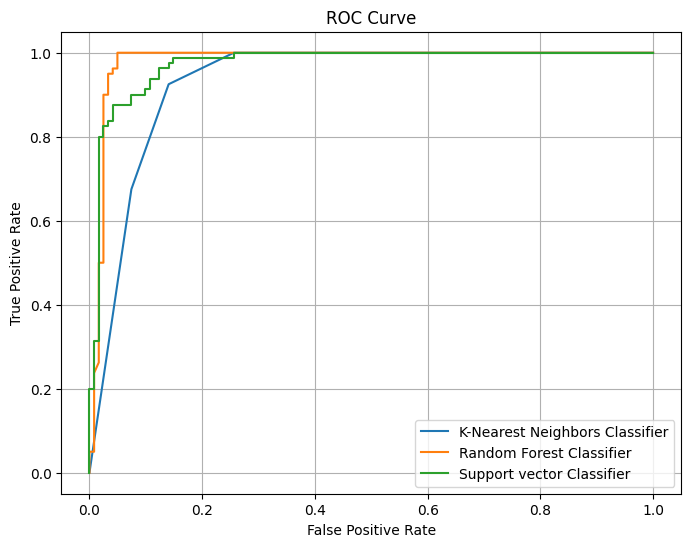

In [17]:
# Define a function to plot the ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

# Plot ROC curve for both models
y_test_binary = (y_test == 2).astype(int)

plt.figure(figsize=(8, 6))
plot_roc_curve(knn_model, X_test, y_test_binary, 'K-Nearest Neighbors Classifier')
plot_roc_curve(rf_model, X_test, y_test_binary, 'Random Forest Classifier')
plot_roc_curve(svc_model, X_test, y_test_binary, 'Support vector Classifier')
plt.show()


We know that that the curve that gets more closer to one in the True Positive Rate is the one with the best performance. As we predicted before, the more accurate classifier for this problem in the RF, followed by the SVC and finally by the KNN.

# Feature selection

In order to know if the features that we are using are relevant for the training of the algorithm, we perform some feature selection.

### K_NEAREST NEIGHBORS

For the KNN we use SelectKBest algorithm and we maintain the k encountered before.

In [18]:
classifier = KNeighborsClassifier()

fs_KNN, fs_KNN_parameter, fs_KNN_accuracy, fs_KNN_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = knn_parameter, feature_selector=True)

Total quantity of features after one hot encoding :13

Selected features are:
Number of selected features: 5
Selected features: ['num__ADI_R_VERBAL_TOTAL_BV', 'num__ADOS_TOTAL', 'cat__PIQ_TEST_TYPE_RAVENS', 'cat__PIQ_TEST_TYPE_WASI', 'cat__PIQ_TEST_TYPE_WISC']

Non selected features are:
Number of non selected features: 8
Selected features: ['num__AGE_AT_SCAN' 'num__SEX' 'num__FIQ' 'num__VIQ' 'num__PIQ'
 'cat__PIQ_TEST_TYPE_DAS' 'cat__PIQ_TEST_TYPE_STANFORD'
 'cat__PIQ_TEST_TYPE_WAIS']


C:\Users\auran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=13 is greater than n_features=12. All the features will be returned.
  warnings.warn(


The results show that the most important features are ADI_R_VERBAL_TOTAL_BV, ADOS_TOTAL and test sub-categories PIQ_TEST_TYPE_RAVENS, PIQ_TEST_TYPE_WASI, PIQ_TEST_TYPE_WISC. 

The fact that it has a better performance using the subcategories of a test, but without using the test is an unpredictable result, that seems contradictory to the meaning of the feature.

In [19]:
# Valutazione del modello sui dati di test
y_pred = fs_KNN.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.910
Precisione: 0.919
Richiamo: 0.934
F1-score: 0.926


However, we can see that the testing accuracy increased from 0.886 to 0.910, which is a good result.

### RANDOM FOREST CLASSIFIER

For the RF we use the Recursive Feature Elimination and the quantity of trees is set by the best one achieved before.

In [20]:
classifier = RandomForestClassifier(random_state=1234)

fs_RF, fs_RF_parameter, fs_RF_accuracy, fs_RF_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = rf_parameter, feature_selector=True)

Total quantity of features after one hot encoding :13

Selected features are:
Number of selected features: 12
Selected features: ['num__AGE_AT_SCAN', 'num__SEX', 'num__FIQ', 'num__VIQ', 'num__PIQ', 'num__ADI_R_VERBAL_TOTAL_BV', 'num__ADOS_TOTAL', 'cat__PIQ_TEST_TYPE_DAS', 'cat__PIQ_TEST_TYPE_RAVENS', 'cat__PIQ_TEST_TYPE_WAIS', 'cat__PIQ_TEST_TYPE_WASI', 'cat__PIQ_TEST_TYPE_WISC']

Non selected features are:
Number of non selected features: 1
Selected features: ['cat__PIQ_TEST_TYPE_STANFORD']


The results show that the most important features are AGE_AT_SCAN, SEX, FIQ, VIQ, PIQ, ADI_R_VERBAL_TOTAL_BV, ADOS_TOTAL,and the test subtypes PIQ_TEST_TYPE_DAS, PIQ_TEST_TYPE_RAVENS, PIQ_TEST_TYPE_WAIS, PIQ_TEST_TYPE_WASI and PIQ_TEST_TYPE_WISC.


In this way only one feature is left behind, which is PIQ_TEST_TYPE_STANFORD, that indeed has very few subjects.

In [21]:
# Valutazione del modello sui dati di test
y_pred = fs_RF.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.955
Precisione: 0.959
Richiamo: 0.967
F1-score: 0.963


In this case we observe that the accuracy didn't increased, but it maintained  equal to 0.955.

### Support vector machine

The linear support vector machine uses RFE as well to select the best features.

In [22]:
classifier = CalibratedClassifierCV(LinearSVC(dual=False))

fs_SVM, fs_SVM_parameter, fs_SVM_accuracy, fs_SVM_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier,  parameters_grid_search = svc_parameter, feature_selector=True)

Total quantity of features after one hot encoding :13

Selected features are:
Number of selected features: 6
Selected features: ['num__ADI_R_VERBAL_TOTAL_BV', 'num__ADOS_TOTAL', 'cat__PIQ_TEST_TYPE_DAS', 'cat__PIQ_TEST_TYPE_RAVENS', 'cat__PIQ_TEST_TYPE_WASI', 'cat__PIQ_TEST_TYPE_WISC']

Non selected features are:
Number of non selected features: 7
Selected features: ['num__AGE_AT_SCAN' 'num__SEX' 'num__FIQ' 'num__VIQ' 'num__PIQ'
 'cat__PIQ_TEST_TYPE_STANFORD' 'cat__PIQ_TEST_TYPE_WAIS']


In this case the selected features were ADI_R_VERBAL_TOTAL_BV, ADOS_TOTAL, PIQ_TEST_TYPE_DAS, PIQ_TEST_TYPE_RAVENS, PIQ_TEST_TYPE_WASI and PIQ_TEST_TYPE_WISC. We observe again that FIQ, PIQ and VIQ are not present, but their subtypes are important.

In [23]:
# Valutazione del modello sui dati di test
y_pred = fs_SVM.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.886
Precisione: 0.945
Richiamo: 0.860
F1-score: 0.900


In this case we observe a worst accuracy than before (0.905 vs 0.886). So the selection it's not really benefitial.

# Outlier Detection

Now we want to check if the possible presence of outlier that we checked  during the exploration is really affecting the performance of our classifiers.

The following function uses Local Outlier Factor to determine if a subject can be considered as outlier or not, the contamination_factor is set by a grid search. It returns the datasets without outliers subjects.

In [24]:
def outlier_detector(dataset, diagnosis, contamination_factor):
    dataset_outliers = dataset.select_dtypes(include=[np.number])
    X = dataset_outliers.values

    # Initialize Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=10, contamination=contamination_factor)  # Adjust parameters as needed
    '''n_neighbors | if too small: model sensible to noise and random outliers
                 if too large: diculties in local outliers detection, in particular if in absence oa a uniform distribution
       contamination | data portion expected as outliers'''
    # Fit the model and predict outliers
    outliers = lof.fit_predict(X)

    # Print number of detected outliers
    print(f"___________________\nNumber of outliers detected: {np.sum(outliers == -1)}")

    # outliers == -1 indicates outliers, 1 indicates inliers
    dataset_outliers['outlier'] = outliers

    outlier_subjects = dataset_outliers[dataset_outliers['outlier'] == -1]

    pd.set_option('display.max_columns', None); outlier_subjects.T

    dataset_without_outliers = dataset[dataset_outliers['outlier'] == 1]
         
    diagnosis_without_outliers = diagnosis[dataset_outliers['outlier'] == 1]

    return dataset_without_outliers, diagnosis_without_outliers, lof

We implement the grid search to find the best contamination factor for each one of the classifiers and we check their performances.

In [25]:
# Initialize dictionaries to store best accuracy and contamination for each classifier
best_accuracies = {KNeighborsClassifier: 0, RandomForestClassifier: 0, CalibratedClassifierCV: 0}
best_models = {KNeighborsClassifier: 0, RandomForestClassifier: 0, CalibratedClassifierCV: 0}
best_parameters = {KNeighborsClassifier: 0, RandomForestClassifier: 0, CalibratedClassifierCV: 0}
best_contaminations = {KNeighborsClassifier: None, RandomForestClassifier: None, CalibratedClassifierCV: None}


# Initialize a variable to store the best overall accuracy and corresponding classifier
best_overall_accuracy = 0
best_overall_classifier = None
best_overall_contamination = None

contamination_factor = [0.001, 0.0015, 0.006, 0.008]

for value in contamination_factor:

    ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers, _ = outlier_detector(ASD_phenotypic, ASD_diagnosis,value)

    X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

    categorical_columns = X_train.select_dtypes(include=['object']).columns
    categorical_features = categorical_columns.tolist()

    # Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
    sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

    # Applica SMOTE-NC per generare nuovi esempi sintetici
    X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)
    sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

    # Applica SMOTE-NC per generare nuovi esempi sintetici
    X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

    classifiers = [KNeighborsClassifier(), RandomForestClassifier(random_state=1234), CalibratedClassifierCV(LinearSVC(dual=False))]
    for classifier in classifiers:
        print(f"\n_____\nEvaluating classifier: {type(classifier).__name__}")
        print("with contamination factor = " + str(value))
        
        model, parameters, accuracy, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)
        # Update best accuracy and contamination for the specific classifier
        classifier_type = type(classifier)

        if accuracy > best_accuracies[classifier_type]:
            best_accuracies[classifier_type] = accuracy
            best_parameters[classifier_type] = parameters
            best_contaminations[classifier_type] = value
            best_models[classifier_type] = model
        
        # Update best overall accuracy and corresponding classifier and contamination
        if accuracy > best_overall_accuracy:
            best_overall_accuracy = accuracy
            best_overall_classifier = classifier_type
            best_overall_contamination = value

# Print the best results for each classifier
for classifier_type in best_accuracies:
    print(f"\nBest contamination factor for {classifier_type.__name__}: {best_contaminations[classifier_type]} with accuracy: {best_accuracies[classifier_type]}")

# Print the best overall result
print(f"\nBest overall contamination factor: {best_overall_contamination} with accuracy: {best_overall_accuracy} for classifier: {best_overall_classifier.__name__}")

___________________
Number of outliers detected: 1

_____
Evaluating classifier: KNeighborsClassifier
with contamination factor = 0.001
Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__n_neighbors': 3}, Accuracy: 0.854 (±0.021), Precision: 0.948, Recall: 0.752, F1-score: 0.837
Parameters: {'classifier__n_neighbors': 5}, Accuracy: 0.853 (±0.044), Precision: 0.957, Recall: 0.738, F1-score: 0.831
Parameters: {'classifier__n_neighbors': 7}, Accuracy: 0.851 (±0.029), Precision: 0.968, Recall: 0.727, F1-score: 0.828
Parameters: {'classifier__n_neighbors': 9}, Accuracy: 0.844 (±0.024), Precision: 0.991, Recall: 0.694, F1-score: 0.815
Parameters: {'classifier__n_neighbors': 11}, Accuracy: 0.842 (±0.027), Precision: 0.995, Recall: 0.687, F1-score: 0.811

Best parameter founded:
[3]
Accuracy with best parameter: 0.8543758043758045

_____
Evaluating classifier: RandomForestClassifier
with contamination factor = 0.001
Risultati della cross-vali

We found the following outcomes for the training:
- Best contamination factor for KNeighborsClassifier: 0.008 with accuracy: 0.8663719766472061
- Best contamination factor for RandomForestClassifier: 0.006 with accuracy: 0.9359132610508757
- Best contamination factor for CalibratedClassifierCV: 0.006 with accuracy: 0.8901918265221018

Highlighting that RandomForestClassifier is one more time the most accurate.

Then we check the accuracies on the test sets.

### K-NEAREST NEIGHBORS

In [27]:
# Valutazione del modello sui dati di test
model = best_models[type(KNeighborsClassifier())]
y_pred = model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.854
Precisione: 0.953
Richiamo: 0.810
F1-score: 0.876


Previous results were:
- Without feature selection - 0.886 
- Without feature selection - 0.910

And now we have:
- With outlier detection - 0.854

That its worst than the others. So maybe it's not benefitial for the KNN to eliminate the outliers.

### RANDOM FOREST CLASSIFIER

In [28]:
# Valutazione del modello sui dati di test
model = best_models[type(RandomForestClassifier(random_state=1234))]
y_pred = model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.965
Precisione: 0.992
Richiamo: 0.952
F1-score: 0.972


Previous results were:
- Without feature selection - 0.955
- Without feature selection - 0.955

And now we have:
- With outlier detection - 0.965

So, it's feasible to achieve and higher accuracy with the outliers elimination.

### SUPPORT VECTOR MACHINE

In [29]:
# Valutazione del modello sui dati di test
model = best_models[type(CalibratedClassifierCV(LinearSVC(dual=False)))]
y_pred = model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.889
Precisione: 0.964
Richiamo: 0.857
F1-score: 0.908


Previous results were:
- Without feature selection - 0.905
- Without feature selection - 0.886

And now we have:
- With outlier detection - 0.889

Which is better than the achieved by the model of feature selection, but worst than the first one.

To have a visual idea of the eliminated outliers, we perfomed a PCA transformation of the space to 2 dimensions for the case of 0.006 contamination factor.

___________________
Number of outliers detected: 5


C:\Users\auran\AppData\Local\Temp\ipykernel_2316\4270060057.py:18: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers


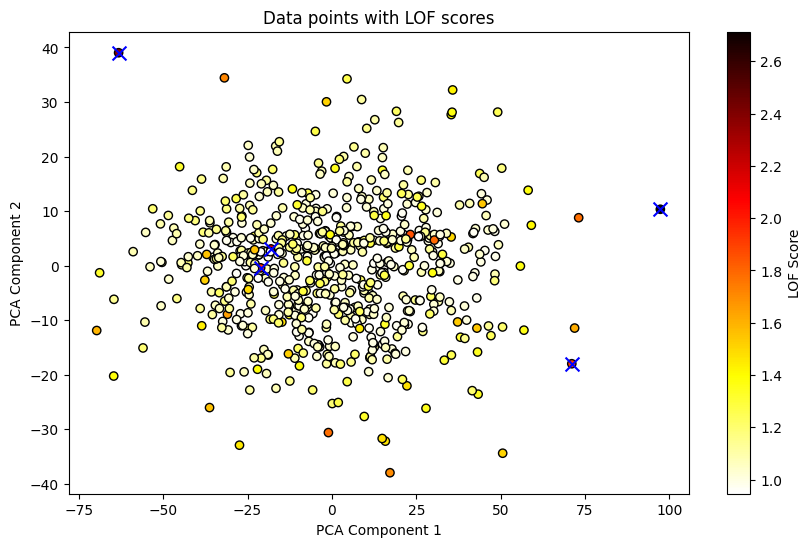

In [ ]:
ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers, lof = outlier_detector(ASD_phenotypic, ASD_diagnosis, best_overall_contamination)

num_features = ASD_phenotypic.select_dtypes(np.number)
X = num_features.values
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
outliers = X_reduced[ASD_phenotypic_without_outliers.index]
outlier_indices = ASD_phenotypic.index.difference(ASD_phenotypic_without_outliers.index)
outliers = X_reduced[outlier_indices]

lof_scores = lof.negative_outlier_factor_

# Plot the data points with color indicating LOF scores
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=-lof_scores, cmap='hot_r', edgecolor='k', label='Inliers')
plt.colorbar(label='LOF Score')
plt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Data points with LOF scores')
plt.show()

We can see that the dots with higher LOF scores were eliminated. Three of them are placed peripherical, but two are in a dense region (this could happen due to the 2d transformation.)

## Visualization of the random tree decisions

Now that we have seen that RF is the best classifier, we would like to see if we can extract interesting information from the decision mechanisms that it uses.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

categorical_columns = X_train.select_dtypes(include=['object','category']).columns
categorical_features = categorical_columns.tolist()

# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)


In [ ]:
classifier = RandomForestClassifier(random_state=1234)
best_trees = fs_RF_parameter[0]
sel_features = fs_RF_parameter[1]
vis_RF, vis_RF_parameter, vis_RF_accuracy, vis_RF_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = [best_trees] , feature_selector=True, parameters_feature_selector=[sel_features])

Total quantity of features after one hot encoding :12

Selected features are:
Number of selected features: 12
Selected features: ['num__AGE_AT_SCAN', 'num__SEX', 'num__FIQ', 'num__VIQ', 'num__PIQ', 'num__ADI_R_VERBAL_TOTAL_BV', 'num__ADOS_TOTAL', 'cat__PIQ_TEST_TYPE_DAS', 'cat__PIQ_TEST_TYPE_RAVENS', 'cat__PIQ_TEST_TYPE_WAIS', 'cat__PIQ_TEST_TYPE_WASI', 'cat__PIQ_TEST_TYPE_WISC']

Non selected features are:
Number of non selected features: 0
Selected features: []


However, as many trees are created using random selection of the features to split, we haven't a way to see a good tree partition.

In [ ]:

# Define your feature and target names
feature_names = vis_RF_selected_features

target_names = ["Autistic", "Control"]  # Adjust according to your target classes

In [ ]:
transformer = vis_RF.named_steps['preprocessor']
X_test_transformed = transformer.transform(X_test)
X_train_transformed = transformer.transform(X_train)

X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformer.get_feature_names_out())
X_test_transformed = X_test_transformed_df[feature_names]
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformer.get_feature_names_out())
X_train_transformed = X_train_transformed_df[feature_names]


# Evaluate each tree in the forest
# Evaluate each tree in the forest

# Access the random forest classifier from the pipeline
rf = vis_RF.named_steps['classifier']

accuracies = []
for i, tree in enumerate(rf.estimators_):
    # Make predictions with the individual tree
    y_pred = tree.predict(X_test_transformed.values)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append((i, accuracy))

# Find the tree with the highest accuracy
most_accurate_tree_index, highest_accuracy = max(accuracies, key=lambda x: x[1])
most_accurate_tree = rf.estimators_[most_accurate_tree_index]

print(f"The most accurate tree is tree number {most_accurate_tree_index} with accuracy of {highest_accuracy:.2f}")


The most accurate tree is tree number 46 with accuracy of 0.17


In this case we saw that the tree that better classify the test data has a accuracy of only 0.17. So it's not reliable to learn one rule from there.

In [ ]:
from sklearn.tree import plot_tree

# Export one of the trees from the forest
tree = rf.estimators_[most_accurate_tree_index]

# Plot the tree
plt.figure(figsize=(200,100))
plot_tree(most_accurate_tree, feature_names=feature_names, class_names=target_names, filled=True, rounded=True, fontsize=12)
plt.show()

We can see that there is a huge quantity of splittings, that make more difficult to understand the mechanisms of decision.

Maybe an usefull insight can be achieved seeing the feature importance.

Feature ranking:
1. feature 5 : num__AGE_AT_SCAN (0.4307995507524282)
2. feature 6 : num__SEX (0.20670393372688173)
3. feature 0 : num__FIQ (0.0807408675465991)
4. feature 3 : num__VIQ (0.0628004717617452)
5. feature 2 : num__PIQ (0.060089497629879154)
6. feature 4 : num__ADI_R_VERBAL_TOTAL_BV (0.057019839900997696)
7. feature 10 : num__ADOS_TOTAL (0.046478453306816304)
8. feature 8 : cat__PIQ_TEST_TYPE_DAS (0.02145602752260914)
9. feature 11 : cat__PIQ_TEST_TYPE_RAVENS (0.017625549444927793)
10. feature 1 : cat__PIQ_TEST_TYPE_WAIS (0.007499588590271411)
11. feature 7 : cat__PIQ_TEST_TYPE_WASI (0.005789913163756446)
12. feature 9 : cat__PIQ_TEST_TYPE_WISC (0.0029963066530879364)


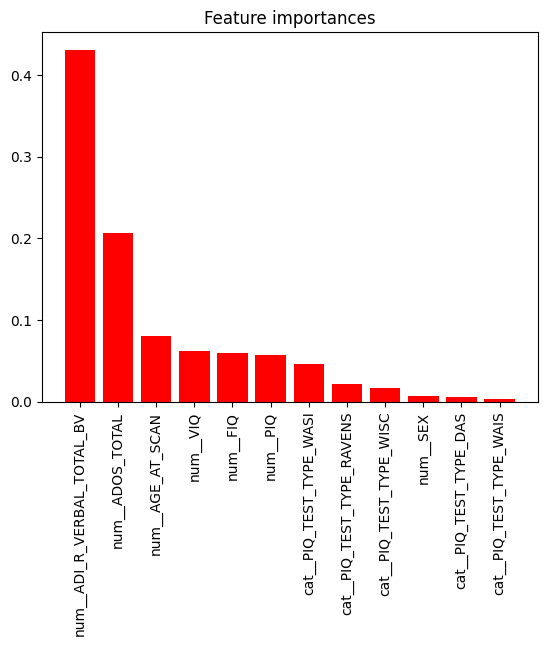

In [ ]:

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]


# Print feature ranking
print("Feature ranking:")
for f in range((X_train_transformed.shape[1])):
    print(f"{f + 1}. feature {indices[f]} : {feature_names[f]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_transformed.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train_transformed.shape[1]), X_train_transformed.columns[indices], rotation=90)
plt.xlim([-1, X_train_transformed.shape[1]])
plt.show()


We can see that the more relevant feature for the decision is ADI_R_VERBAL_TOTAL_BV, followed by ADOS_TOTAL. This outcome seems to be meaningfull due to the fact that this two feature are the only one that are really created to account autism. But we can't overcome the fact that they are also the ones that has the biggest quantity of missing values, so we have to be carefull with the analysis of this results.